In [107]:
import sys
import os
sys.argv = ['']

In [108]:
import pickle
import matplotlib.pyplot as plt

import numpy as np

from main import get_args
from van_code.utils import *
from van_code.runners import init

In [109]:
cwd = os.path.abspath(os.getcwd())
data_path = os.path.abspath(os.path.join(cwd, '..', 'data'))

# print(data_path)

This notebook loads some pre-trained models and data on lattices up to $64\times 64$ at $\beta=0.44$. Results for $128\times 128$ are left out to allow a better portability of the code.
Running this notebook will:
1) Load the data of Multilevel, HAN and Cluster algorithm.
2) Show and compare learning curves (i.e., the loss) for different lattice sizes.
3) Perform a thorough analysis by reporting on ESS, compatibility of estimators, autocorrelation analysis, Free energy estimation and more.

# <h1 style="background-color:red;">Data Loading</h1>


In [115]:
Lf=np.asarray([8,16,32,64])
nblocks=[2,3,4,5]

In [116]:
args=get_args()
if isinstance(args.kernel_size, int):
    args.kernel_size = [args.kernel_size, args.kernel_size]

model, path, info = init(args)
path = path.replace("[5, 5]", "5")
del model

In [117]:
train_path = os.path.join(data_path,'training', path)
res_path = os.path.join(data_path,'results', path)
res_path

'/Users/kimnicoli/Projects/multilevelRG/data/results/Lf16_beta0.44_nblocks3_PCNNdepth3_width16_half_ker6_CCNNhs16_ks5'

-----

# Load data Multilevel

In [118]:
path_md = res_path+'_measures_modedrop.log'
path_mh = res_path+'_measuresIMH'+'.log'
path_dict = train_path+'_historyDict.pkl'
hist=[]
metrics=[]
metrics_mh=[]

for i in range(len(Lf)):
    path_load=path_md.replace("Lf16", "Lf"+str(Lf[i]))
    path_load=path_load.replace("nblocks3", "nblocks"+str(nblocks[i]))
    metrics.append(get_data_modedrop(path_load))
    path_load=path_mh.replace("Lf16", "Lf"+str(Lf[i]))
    path_load=path_load.replace("nblocks3", "nblocks"+str(nblocks[i]))
    metrics_mh.append(get_data_MCMC(path_load))
    path_load=path_dict.replace("Lf16", "Lf"+str(Lf[i]))
    path_load=path_load.replace("nblocks3", "nblocks"+str(nblocks[i]))
    with open(path_load, 'rb') as handle:
        history= pickle.load(handle)
    hist.append(history)


-----

# Load data Cluster algorithm

In [119]:
path_cluster = res_path+'_measuresCluster'+'.log'

metrics_cluster=[]
for i in range(len(Lf)):
    path_load=path_cluster.replace("Lf16", "Lf"+str(Lf[i]))
    path_load=path_load.replace("nblocks3", "nblocks"+str(nblocks[i]))
    metrics_cluster.append(get_data_MCMC(path_load))


-----

# Load data HAN

In [126]:
han_mh_path = os.path.join(data_path,'results', 'han_L8_beta0.44measures_imh.log')
han_md_path = os.path.join(data_path,'results', 'han_L8_beta0.44measures_md.log')

metrics_han_mh=[]
metrics_han_md=[]
for i in range(len(Lf)):
    metrics_han_mh.append(get_data_MCMC(han_mh_path.replace("L8", "L"+str(Lf[i]))))
    metrics_han_md.append(get_data_modedrop(han_md_path.replace("L8", "L"+str(Lf[i]))))

metrics_han_mh = np.asarray(metrics_han_mh)
metrics_han_md = np.asarray(metrics_han_md)


------

# <h1 style="background-color:red;">Analysis</h1>








### Learning Curve

In [127]:
metrics = np.asarray(metrics)
metrics_cluster = np.asarray(metrics_cluster)
metrics_mh = np.asarray(metrics_mh)

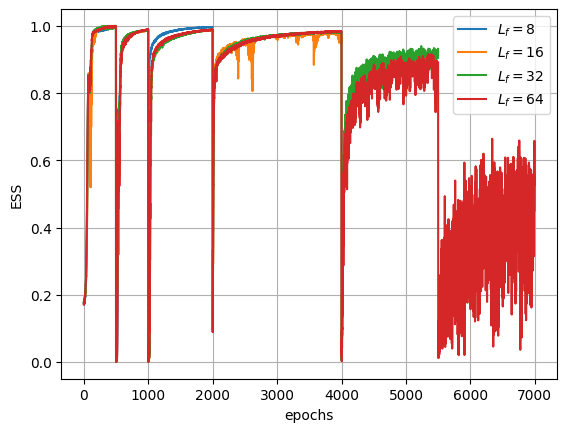

In [128]:
for i in range(len(Lf)):
    plt.plot(hist[i]['ESS'],label=r'$L_f=$'+str(Lf[i]))

plt.legend()
plt.grid()
plt.xlabel('epochs')
plt.ylabel('ESS')
plt.show()

### Free energy F/R

In [129]:
rF_plot=np.asarray(metrics[:,0])
fF_plot=np.asarray(metrics[:,2])
rF_HAN_plot=np.asarray(metrics_han_md[:,0])
fF_HAN_plot=np.asarray(metrics_han_md[:,2])

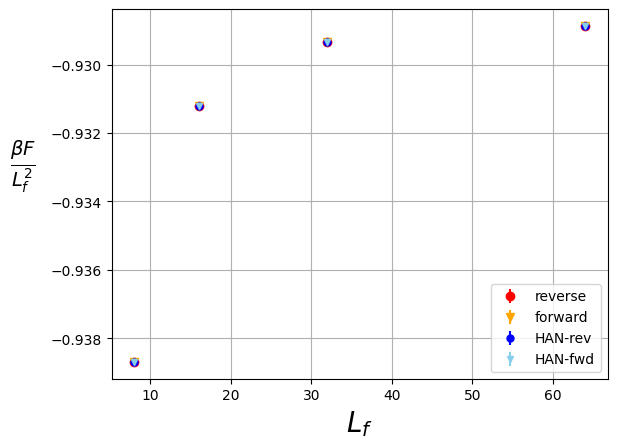

In [137]:
plt.errorbar(Lf,rF_plot[:,0]/Lf**2, yerr=rF_plot[:,1]/Lf**2, fmt='o', label='reverse',c='red',)
plt.errorbar(Lf,fF_plot[:,0]/Lf**2, yerr=fF_plot[:,1]/Lf**2, fmt='v', label='forward',c='orange',)
plt.errorbar(Lf,rF_HAN_plot[:,0]/Lf**2, yerr=rF_HAN_plot[:,1]/Lf**2, markersize=5, fmt='o', label='HAN-rev',c='blue',)
plt.errorbar(Lf,fF_HAN_plot[:,0]/Lf**2, yerr=fF_HAN_plot[:,1]/Lf**2, markersize=5, fmt='v', label='HAN-fwd',c='skyblue',)

plt.legend()
plt.xlabel(r'$L_f$', fontsize=20)
plt.ylabel(r'$\frac{\beta F} {L_f^2}$', rotation=0, labelpad=20, fontsize=20)
plt.grid()
plt.show()

### Effective Sampling Size (ESS)

In [139]:
rESS_plot=np.asarray(metrics[:,1])
fESS_plot=np.asarray(metrics[:,3])

HAN_rESS_plot=np.asarray(metrics_han_md[:,1])
HAN_fESS_plot=np.asarray(metrics_han_md[:,3])


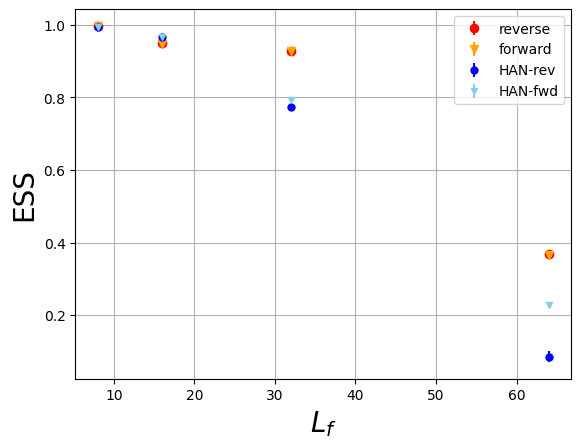

In [140]:
# @ELIA: it is strange the fESS is higher than the rESS. Are you sure these are computed correctly?

plt.errorbar(Lf,rESS_plot[:,0], yerr=rESS_plot[:,1], fmt='o', label='reverse',c='red',)
plt.errorbar(Lf,fESS_plot[:,0], yerr=fESS_plot[:,1], fmt='v', label='forward',c='orange',)
plt.errorbar(Lf,HAN_rESS_plot[:,0], yerr=HAN_rESS_plot[:,1], markersize=5, fmt='o', label='HAN-rev',c='blue',)
plt.errorbar(Lf,HAN_fESS_plot[:,0], yerr=HAN_fESS_plot[:,1], markersize=5, fmt='v', label='HAN-fwd',c='skyblue',)

plt.legend()
plt.grid()

plt.xlabel(r'$L_f$', fontsize=20)
plt.ylabel(r'ESS', fontsize=20)
plt.show()

###  Mode dropping estimator

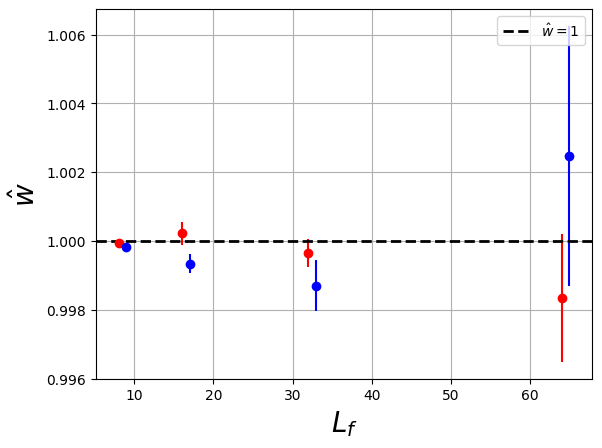

In [143]:
md_plot=np.asarray(metrics[:,-3])
HAN_md_plot=np.asarray(metrics_han_md[:,-3])

plt.errorbar(Lf,md_plot[:,0], yerr=md_plot[:,1], fmt='o',c='r',)
plt.errorbar(Lf+[1],HAN_md_plot[:,0], yerr=HAN_md_plot[:,1], fmt='o',c='b',)
plt.axhline(1.0, color='k', linestyle='--', linewidth=2, label=r'$\hat{w}=1$')
plt.grid()
plt.legend()
plt.xlabel(r'$L_f$', fontsize=20)
plt.ylabel(r'$\hat{w}$', fontsize=20)
plt.show()

### $U$ (Internal energy) and $|m|$ (absolute magnetization)
#### Comparison with cluster method and autocorrelation analysis

In [144]:
U_plot=np.asarray(metrics[:,-2])
U_imh_plot=np.asarray(metrics_mh[:,-4])
HAN_U_plot=np.asarray(metrics_han_md[:,-2])
HAN_U_imh_plot=np.asarray(metrics_han_mh[:,-4])
U_cluster_plot=np.asarray(metrics_cluster[:,-4])

m_plot=np.asarray(metrics[:,-1])
m_imh_plot=np.asarray(metrics_mh[:,-2])
HAN_m_plot=np.asarray(metrics_han_md[:,-1])
HAN_m_imh_plot=np.asarray(metrics_mh[:,-2])
m_cluster_plot=np.asarray(metrics_cluster[:,-2])

tU_imh_plot=np.asarray(metrics_mh[:,-3])
HAN_tU_imh_plot=np.asarray(metrics_han_mh[:,-3])
tU_cluster_plot=np.asarray(metrics_cluster[:,-3])

tm_imh_plot=np.asarray(metrics_mh[:,-1])
HAN_tm_imh_plot=np.asarray(metrics_han_mh[:,-1])
tm_cluster_plot=np.asarray(metrics_cluster[:,-1])


## Compatibility of Estimators

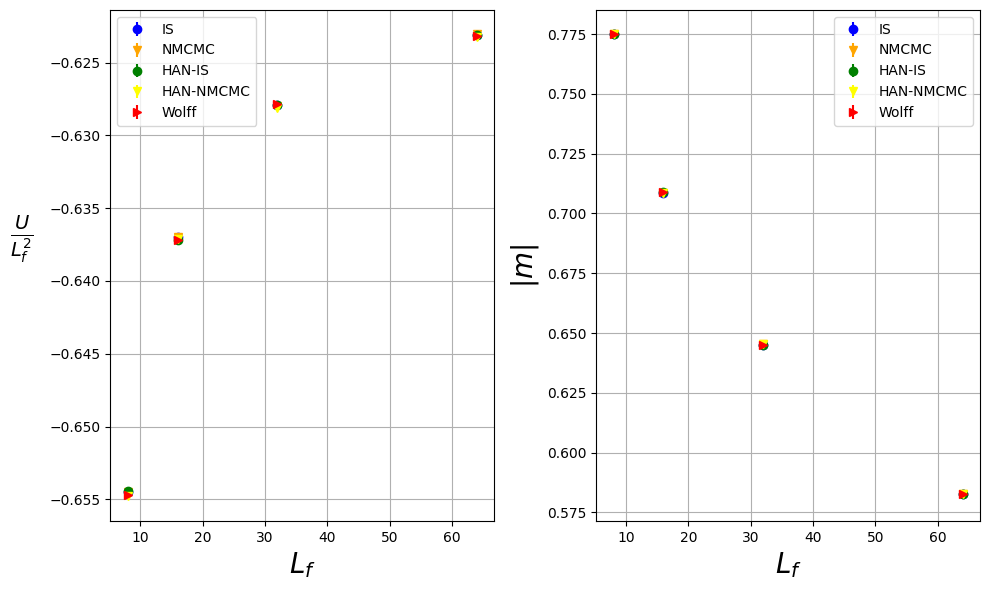

In [151]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))

ax1.errorbar(Lf,U_plot[:,0]/Lf**2, yerr=U_plot[:,1]/Lf**2, fmt='o', label='IS',c='b',)
ax1.errorbar(Lf,U_imh_plot[:,0]/Lf**2, yerr=U_imh_plot[:,1]/Lf**2, fmt='v', label='NMCMC',c='orange',)
ax1.errorbar(Lf,HAN_U_plot[:,0]/Lf**2, yerr=HAN_U_plot[:,1]/Lf**2, fmt='o', label='HAN-IS',c='green',)
ax1.errorbar(Lf,HAN_U_imh_plot[:,0]/Lf**2, yerr=HAN_U_imh_plot[:,1]/Lf**2, fmt='v', label='HAN-NMCMC',c='yellow',)
ax1.errorbar(Lf,U_cluster_plot[:,0]/Lf**2, yerr=U_cluster_plot[:,1]/Lf**2, fmt='>', label='Wolff',c='r',)
ax1.legend()
ax1.grid()
ax1.set_xlabel(r'$L_f$', fontsize=20)
ax1.set_ylabel(r'$ \frac{U}{L_f^2}$', rotation=0, labelpad=20, fontsize=20)


ax2.errorbar(Lf,m_plot[:,0], yerr=m_plot[:,1], fmt='o', label='IS',c='b',)
ax2.errorbar(Lf,m_imh_plot[:,0], yerr=m_imh_plot[:,1], fmt='v', label='NMCMC',c='orange',)
ax2.errorbar(Lf,HAN_m_plot[:,0], yerr=HAN_m_plot[:,1], fmt='o', label='HAN-IS',c='green',)
ax2.errorbar(Lf,HAN_m_imh_plot[:,0], yerr=HAN_m_imh_plot[:,1], fmt='v', label='HAN-NMCMC',c='yellow',)
ax2.errorbar(Lf,m_cluster_plot[:,0], yerr=m_cluster_plot[:,1], fmt='>', label='Wolff',c='r',)
ax2.legend()
ax2.grid()
ax2.set_xlabel(r'$L_f$',fontsize=20)
ax2.set_ylabel(r'$|m|$',fontsize=20)

plt.tight_layout()
plt.show()

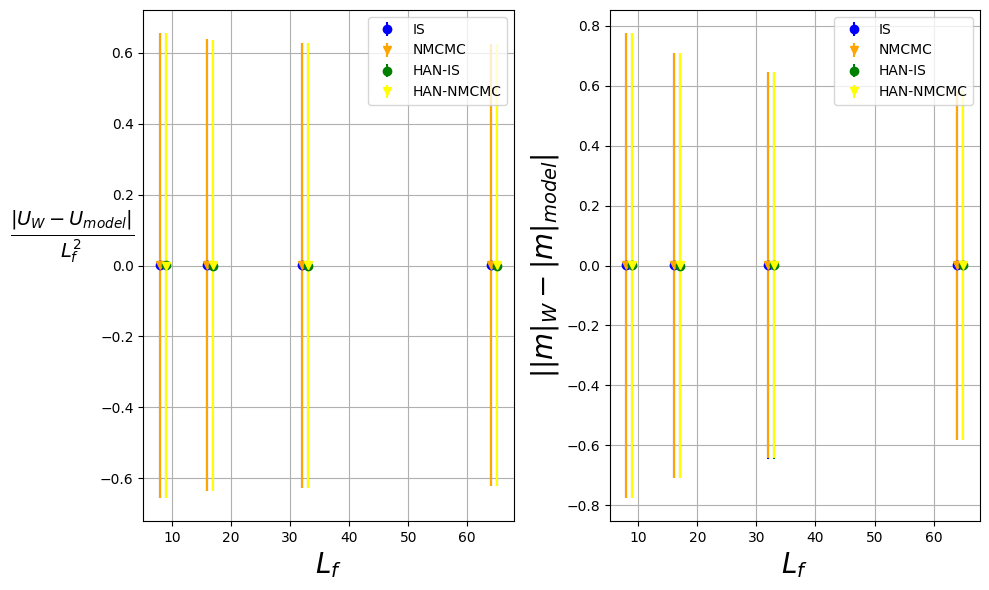

In [155]:
# Same plot as above but taking the difference wrt to Wolff (ground truth)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))

ax1.errorbar(Lf,np.abs(U_plot[:,0]-U_cluster_plot[:,0])/Lf**2, yerr=np.sqrt(U_cluster_plot[:,0]**2 + U_plot[:,1]**2)/Lf**2, fmt='o', label='IS',c='b',)
ax1.errorbar(Lf,np.abs(U_imh_plot[:,0]-U_cluster_plot[:,0])/Lf**2, yerr=np.sqrt(U_cluster_plot[:,0]**2 + U_imh_plot[:,1]**2)/Lf**2, fmt='v', label='NMCMC',c='orange',)
ax1.errorbar(Lf+[1],np.abs(HAN_U_plot[:,0]-U_cluster_plot[:,0])/Lf**2, yerr=np.sqrt(U_cluster_plot[:,0]**2 + HAN_U_plot[:,1]**2)/Lf**2, fmt='o', label='HAN-IS',c='green',)
ax1.errorbar(Lf+[1],np.abs(HAN_U_imh_plot[:,0]-U_cluster_plot[:,0])/Lf**2, yerr=np.sqrt(U_cluster_plot[:,0]**2 + HAN_U_imh_plot[:,1]**2)/Lf**2, fmt='v', label='HAN-NMCMC',c='yellow',)
ax1.legend()
ax1.grid()
ax1.set_xlabel(r'$L_f$', fontsize=20)
ax1.set_ylabel(r'$ \frac{\vert U_W - U_{model}\vert}{L_f^2}$', rotation=0, labelpad=20, fontsize=20)


ax2.errorbar(Lf,np.abs(m_plot[:,0]-m_cluster_plot[:,0]), yerr=np.sqrt(m_cluster_plot[:,0]**2 + m_plot[:,1]**2), fmt='o', label='IS',c='b',)
ax2.errorbar(Lf,np.abs(m_imh_plot[:,0]-m_cluster_plot[:,0]), yerr=np.sqrt(m_cluster_plot[:,0]**2 + m_imh_plot[:,1]**2), fmt='v', label='NMCMC',c='orange',)
ax2.errorbar(Lf+[1],np.abs(HAN_m_plot[:,0]-m_cluster_plot[:,0]), yerr=np.sqrt(m_cluster_plot[:,0]**2 + HAN_m_plot[:,1]**2), fmt='o', label='HAN-IS',c='green',)
ax2.errorbar(Lf+[1],np.abs(HAN_m_imh_plot[:,0]-m_cluster_plot[:,0]), yerr=np.sqrt(m_cluster_plot[:,0]**2 + HAN_m_imh_plot[:,1]**2), fmt='v', label='HAN-NMCMC',c='yellow',)
ax2.legend()
ax2.grid()
ax2.set_xlabel(r'$L_f$',fontsize=20)
ax2.set_ylabel(r'$\vert |m|_{W}-|m|_{model} \vert$',fontsize=20)

plt.tight_layout()
plt.show()

## Autocorrelation Analysis


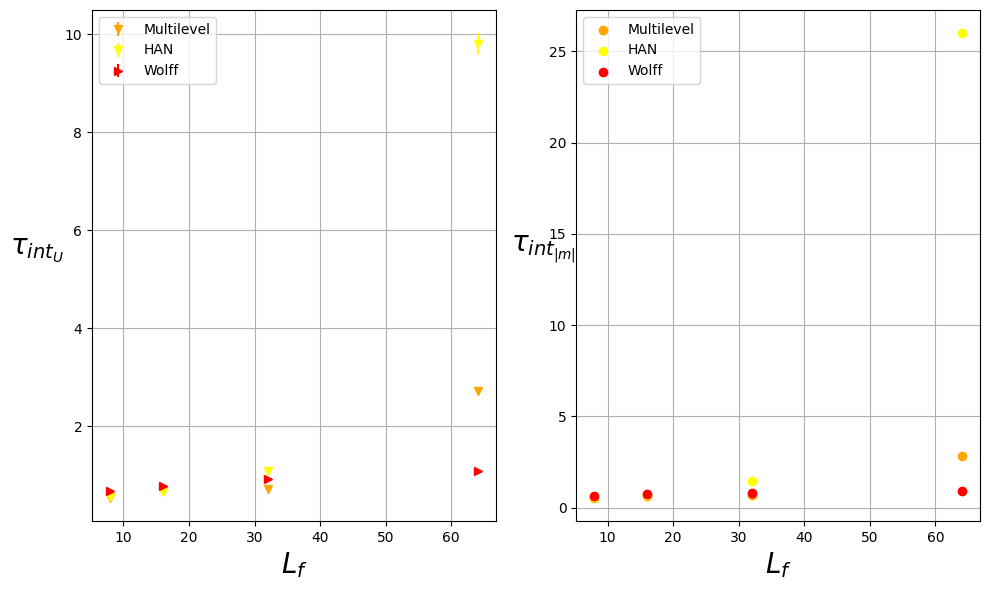

In [157]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))

ax1.errorbar(Lf,tU_imh_plot[:,0], yerr=tU_imh_plot[:,1], fmt='v', label='Multilevel',c='orange',)
ax1.errorbar(Lf,HAN_tU_imh_plot[:,0], yerr=HAN_tU_imh_plot[:,1], fmt='v', label='HAN',c='yellow',)
ax1.errorbar(Lf,tU_cluster_plot[:,0], yerr=tU_cluster_plot[:,1], fmt='>', label='Wolff',c='r',)

ax1.legend()
ax1.grid()
ax1.set_xlabel(r'$L_f$', fontsize=20)
ax1.set_ylabel(r'$\tau_{{int}_U}$', rotation=0, labelpad=20, fontsize=20)

ax2.scatter(Lf,tm_imh_plot[:,0], label='Multilevel',c='orange',)
ax2.scatter(Lf,HAN_tm_imh_plot[:,0], label='HAN',c='yellow',)
ax2.scatter(Lf,tm_cluster_plot[:,0], label='Wolff',c='red',)

ax2.set_xlabel(r'$L_f$', fontsize=20)
ax2.set_ylabel(r'$\tau_{{int}_{|m|}}$', rotation=0, fontsize=20)
ax2.grid()
ax2.legend()
plt.tight_layout()
plt.show()